In this notebook I explore the parameter space for which the SNR is highly degraded by cleaning

In [2]:
%config IPCompleter.use_jedi = False
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append("../../scripts")

# from scripts
# ------------
from signals import protopapas2005, pont2006
np.random.seed(43)

ModuleNotFoundError: No module named 'signals'

# A transit without noise

In [ ]:
# transit
time = np.linspace(0, 20, 10000)
dur = 0.1
depth = 0.8e-2
t0 = time.mean()
n = dur/np.median(np.diff(time))
signal = protopapas2005(time, t0, dur, depth, period=100, c=10)

# white noise
wsigma = 0
white_noise = np.random.normal(0, wsigma, len(time))
flux = white_noise + signal
print(n)

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, signal, c="k", alpha=0.4, lw=2)
plt.ylim(0.98, 1.02)
plt.tight_layout()

# MCMC

In [3]:
from wotan import flatten
from tqdm import tqdm
import celerite
from celerite import terms
# https://github.com/hippke/wotan

ModuleNotFoundError: No module named 'celerite'

# Inclduing white noise

In [ ]:
np.random.seed(47)
plot = False

N = 100000
periods = np.random.uniform(0.1, 5, size=N)*dur
amps = np.random.uniform(0.1, 15, size=N)*depth
sigmas_white = np.random.uniform(1/50, 1, size=N)*depth
snrs = []
cut = 300
intransit = signal  < (1 - depth/2)
i = 0
    
for period, amp, wsigma in zip(tqdm(periods), amps, sigmas_white):

    Q = 10
    w0 = 1/period
    S0 = amp**2 / (w0 * Q)

    var_kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0))
    gp = celerite.GP(var_kernel)
    gp.compute(time)

    _variability = gp.sample()
    _flux = white_noise + signal + _variability
    _flatten_flux, _flatten_trend = flatten(time, _flux, window_length=3*dur, return_trend=True)
    new_depth = np.max([0, np.median(_flatten_flux[~intransit][cut:-cut]) - np.median(_flatten_flux[intransit])])
    w, r = pont2006(time[~intransit][cut:-cut], _flatten_flux[~intransit][cut:-cut])
    snrs.append(new_depth/np.sqrt((w**2)/n + r**2))

    if plot:
        print(period)
        plt.figure()
        plt.plot(time, _flux, ".", lw=2)
        plt.plot(time, _variability + 1,)
        plt.ylim(0.98, 1.02)

        plt.figure()
        plt.plot(time, _flux, ".")
        plt.ylim(0.98, 1.02)

        plt.figure()
        plt.plot(time[~intransit][cut:-cut], _flatten_flux[~intransit][cut:-cut], ".")
        plt.ylim(0.98, 1.02)

        plt.figure()
        plt.plot(time, _flatten_flux, ".")
        plt.xlim(t0 - 5*dur, t0 + 5*dur)
        plt.ylim(0.98, 1.02)

    i += 1

np.save(f"samples_3d.npy", [periods/dur, amps/depth, sigmas_white/depth, snrs])

  0%|                                    | 10/100000 [00:24<68:38:45,  2.47s/it]

In [1]:
intransit

NameError: name 'intransit' is not defined

# No white noise

This time we only explore the relative amplitude and timescale with a 0 white noise

In [11]:
np.random.seed(40)
plot = False

N = 20000
periods = np.random.uniform(0.1, 15, size=N)*dur
amps = np.random.uniform(0.1, 15, size=N)*depth
snrs = []
cut = 300
intransit = signal  < (1 - depth/2)
i = 0
    
for period, amp in zip(tqdm(periods), amps):

    Q = 10
    w0 = 1/period
    S0 = amp**2 / (w0 * Q)

    var_kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0))
    gp = celerite.GP(var_kernel)
    gp.compute(time)

    _variability = gp.sample()
    _flux = signal + _variability
    _flatten_flux, _flatten_trend = flatten(time, _flux, window_length=3*dur, return_trend=True)
    new_depth = np.max([0, np.median(_flatten_flux[~intransit][cut:-cut]) - np.median(_flatten_flux[intransit])])
    w, r = pont2006(time[~intransit][cut:-cut], _flatten_flux[~intransit][cut:-cut])
    snrs.append(new_depth/np.sqrt((w**2)/n + r**2))

    if plot:
        print(period)
        plt.figure()
        plt.plot(time, _flux, ".", lw=2)
        plt.plot(time, _variability + 1,)
        #plt.ylim(0.98, 1.02)

        plt.figure()
        plt.plot(time, _flux, ".")
        #plt.ylim(0.98, 1.02)

        plt.figure()
        plt.plot(time[~intransit][cut:-cut], _flatten_flux[~intransit][cut:-cut], ".")
        #plt.ylim(0.98, 1.02)

        plt.figure()
        plt.plot(time, _flatten_flux, ".")
        plt.xlim(t0 - 5*dur, t0 + 5*dur)
        #plt.ylim(0.98, 1.02)

    i += 1

np.save(f"samples_no_white__timescale_amp_snrs.npy", [periods/dur, amps/depth, snrs])

  0%|          | 5/20000 [00:11<12:28:22,  2.25s/it]


KeyboardInterrupt: 

In [10]:
np.save(f"samples_no_white4.npy", [periods/dur, amps/depth, snrs, """timescale, amplitude, snr. 
timescale and amplitude relative to transit depth"""])

/home/exotic/code/envs/nuance/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


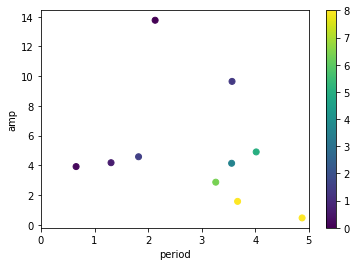

In [40]:
plt.scatter(periods[0:i]/dur, amps[0:i]/depth, c=snrs, vmax=8)
plt.ylabel("amp"); plt.xlabel("period")
plt.xlim(0, 5)
plt.colorbar()